# **Import Libraries**

In [4]:
!pip install emoji
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import numpy as np
import emoji

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Data Extraction**

In [5]:
#read the csv file
data=pd.read_csv("LabeledText.csv")
data

,File Name,Caption,LABEL
0,1.txt,How I feel today #legday #jelly #aching #gym,negative
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive
...,...,...,...
4864,995.txt,OMG. Well done #Eskom! 'Man dies during #LoadS...,positive
4865,996.txt,Feelin' the love in here! #ValentinesDay #caring,positive
4866,997.txt,#blue #eyes can't be #beaten,neutral
4867,998.txt,LA CHUCHA LOUUU TE CHUPO LOS OJOS..!,neutral


The loaded dataset comprises 4,869 rows and spans three columns, detailing 'File Name', 'Caption', and 'Label'. The 'File Name' column may serve as a unique identifier for each record, while the 'Caption' column contains the textual content intended for sentiment analysis. The 'Label' column provides the sentiment classification for each text entry, which is essential for supervised learning. At first glance, the dataset appears structured, but a detailed inspection for preprocessing needs, such as handling missing values or data cleaning, is forthcoming.






**Checking for missing values**

In [6]:
#checking missing values
data.isnull().sum()

File Name    0
Caption      0
LABEL        0
dtype: int64

Great, it seems there are not having any missing values in our dataset.

**Getting Info of Dataset**

In [7]:
#Prompting for info of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4869 entries, 0 to 4868
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File Name  4869 non-null   object
 1   Caption    4869 non-null   object
 2   LABEL      4869 non-null   object
dtypes: object(3)
memory usage: 114.2+ KB


We have dataset with 4869 entries with 2 feature and 1 target variable which is "LABEL'.

**Distribution of the target variable**

<Axes: xlabel='LABEL', ylabel='count'>

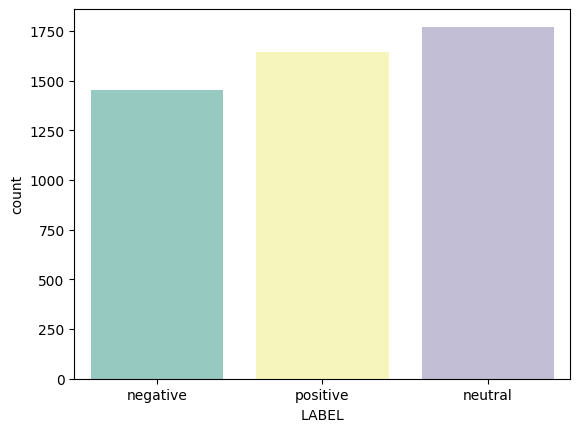

In [8]:
#show the distribution of the categorical variable in 'LABEL' columns (target variable)
sns.countplot(x="LABEL",data=data,palette='Set3')

From the countplot above, we can see that most of the comments are neutral, coming with postive and negative. But overall, our dataset is quite balanced as there is no big and difference between the categories.

# **Data Cleaning**

We are now embarking on the initial phase of our data preprocessing pipeline, which is data cleaning. The objective of this step is to refine our dataset by removing unnecessary or irrelevant noise that can interfere with our analysis. This includes stripping away extraneous characters such as hashtags, mentions, URLs, and emojis in our dataset, which are prevalent in social media texts but often provide little to no value for sentiment analysis. By purging these elements, we aim to achieve a cleaner, more standardized text corpus that will enhance the reliability and performance of our subsequent text processing and machine learning tasks.

**Dropping unwanted columns**

We will now performing dropping the "File Name" columns as it doesn't offer any prediction power in our dataset.

In [9]:
#dropping 'file name' column
data.drop('File Name',axis=1,inplace=True)

In [10]:
#validate the dataset
data.head()

,Caption,LABEL
0,How I feel today #legday #jelly #aching #gym,negative
1,@ArrivaTW absolute disgrace two carriages from...,negative
2,This is my Valentine's from 1 of my nephews. I...,positive
3,betterfeelingfilms: RT via Instagram: First da...,neutral
4,Zoe's first love #Rattled @JohnnyHarper15,positive


**Removal of User Mentions, Hashtags, Retweet, URLs, Newline Characters, Emojis**

In [11]:
def cleaning(text):
  #removing Twitter mentions that start with @ followed by any alphanumeric characters and underscores
  text = re.sub('@[A-Za-z0-9_]+','',text)
  #Removes hashtags symbols (#) but leaves the text of the hashtag in place
  text = re.sub('#','',text)
  #Removes the retweet abbreviation RT when followed by one or more whitespace characters
  text = re.sub('RT[\s]+','',text)
  #Removes URLs that start with http or https followed by any non-whitespace characters
  text = re.sub('https?:\/\/\S+', '', text)
  #Replaces newline characters (\n) with a space
  text = re.sub('\n',' ',text)
  #Removes emojis from the text
  text = emoji.replace_emoji(text, replace='')
  return text

In [12]:
#apply the cleaning function to our "Cleaned_Caption" column
data["Cleaned_Caption"]=data["Caption"].apply(cleaning)

In [13]:
#validate our data
data.head()

,Caption,LABEL,Cleaned_Caption
0,How I feel today #legday #jelly #aching #gym,negative,How I feel today legday jelly aching gym
1,@ArrivaTW absolute disgrace two carriages from...,negative,absolute disgrace two carriages from Bangor h...
2,This is my Valentine's from 1 of my nephews. I...,positive,This is my Valentine's from 1 of my nephews. I...
3,betterfeelingfilms: RT via Instagram: First da...,neutral,betterfeelingfilms: via Instagram: First day o...
4,Zoe's first love #Rattled @JohnnyHarper15,positive,Zoe's first love Rattled


Now we can see from our "Caption" columns, the The dataset has undergone an essential cleaning process, where Twitter-specific noise such as user mentions, hashtags, retweet symbols, and URLs have been stripped away, along with the removal of newline characters and emojis. This refined text data is now purged of extraneous elements that could potentially skew the analysis, ensuring that the focus remains on the substantive content of the tweets for more accurate sentiment analysis

All good, now we are going to perform our data preprocessing step!

# **Data Preprocessing**

After visualize our dataset, we are now delve into preprocessing our dataset. It is a critical phase where raw text is transformed into a clean, normalized format suitable for machine learning. Generally, we will process utilize several common used techniques implemented in the literature reviews such as **Case Normalization**,**Tokenization**, **Stop Word Removal**, **Stemming** and also **Lemmatization** to streamline the dataset and reduce noise.


**Case Normalization**

In [14]:
#define a case normalization function
def case_normalization(text):
  text = re.sub('[^a-zA-Z]', ' ', str(text).lower().strip())
  return text

In [15]:
#apply the funtion into our 'Caption_Norm' column
data["Caption_Normalized"]=data["Cleaned_Caption"].apply(case_normalization)

In [16]:
#validating the dataset
data.head()

,Caption,LABEL,Cleaned_Caption,Caption_Normalized
0,How I feel today #legday #jelly #aching #gym,negative,How I feel today legday jelly aching gym,how i feel today legday jelly aching gym
1,@ArrivaTW absolute disgrace two carriages from...,negative,absolute disgrace two carriages from Bangor h...,absolute disgrace two carriages from bangor ha...
2,This is my Valentine's from 1 of my nephews. I...,positive,This is my Valentine's from 1 of my nephews. I...,this is my valentine s from of my nephews i...
3,betterfeelingfilms: RT via Instagram: First da...,neutral,betterfeelingfilms: via Instagram: First day o...,betterfeelingfilms via instagram first day o...
4,Zoe's first love #Rattled @JohnnyHarper15,positive,Zoe's first love Rattled,zoe s first love rattled


Now, all the text in 'Caption' columns are all converted into lower case.

**Tokenization**

Tokenization is breaking text into smaller parts for easier machine analysis, helping machines understand human language. By breaking down text into tokens, we can analyze and understand the frequency and distribution of words within our dataset. It lays the groundwork for further processing steps,

In [17]:
#Define the function for tokenization
def tokenize_text(text):
    # Tokenize the text
    return word_tokenize(text)

# Create a new column in the DataFrame for the tokenized text
data['Caption_Tokenized'] = data['Caption_Normalized'].apply(tokenize_text)

In [18]:
#validating the dataset
data.head()

,Caption,LABEL,Cleaned_Caption,Caption_Normalized,Caption_Tokenized
0,How I feel today #legday #jelly #aching #gym,negative,How I feel today legday jelly aching gym,how i feel today legday jelly aching gym,"[how, i, feel, today, legday, jelly, aching, gym]"
1,@ArrivaTW absolute disgrace two carriages from...,negative,absolute disgrace two carriages from Bangor h...,absolute disgrace two carriages from bangor ha...,"[absolute, disgrace, two, carriages, from, ban..."
2,This is my Valentine's from 1 of my nephews. I...,positive,This is my Valentine's from 1 of my nephews. I...,this is my valentine s from of my nephews i...,"[this, is, my, valentine, s, from, of, my, nep..."
3,betterfeelingfilms: RT via Instagram: First da...,neutral,betterfeelingfilms: via Instagram: First day o...,betterfeelingfilms via instagram first day o...,"[betterfeelingfilms, via, instagram, first, da..."
4,Zoe's first love #Rattled @JohnnyHarper15,positive,Zoe's first love Rattled,zoe s first love rattled,"[zoe, s, first, love, rattled]"


The 'tokenized_caption' column now contains the tokenized versions of our text data. Each entry is a list of tokens, representing the words from the original captions. This tokenized data lays the groundwork for further preprocessing steps like stop word removal and stemming/lemmatization.

**Stop Word Removal**

Next, we will eliminate common stop words from our tokenized text. Stop words are typically ignored in text analysis because they do not contribute significantly to the meaning of the text. Removing these can help in emphasizing the important words that could be more indicative of the sentiment

In [19]:
# Get the list of English stop words
stop_words = set(stopwords.words('english'))

# Define the function to remove stop words
def clean_stopwords(text):
    return [word for word in text if word not in stop_words]

# Create a new column in the DataFrame for the text without stop word
data['Caption_StopWordRemoval'] = data['Caption_Tokenized'].apply(clean_stopwords)

In [20]:
#validating the data
data.head()

,Caption,LABEL,Cleaned_Caption,Caption_Normalized,Caption_Tokenized,Caption_StopWordRemoval
0,How I feel today #legday #jelly #aching #gym,negative,How I feel today legday jelly aching gym,how i feel today legday jelly aching gym,"[how, i, feel, today, legday, jelly, aching, gym]","[feel, today, legday, jelly, aching, gym]"
1,@ArrivaTW absolute disgrace two carriages from...,negative,absolute disgrace two carriages from Bangor h...,absolute disgrace two carriages from bangor ha...,"[absolute, disgrace, two, carriages, from, ban...","[absolute, disgrace, two, carriages, bangor, h..."
2,This is my Valentine's from 1 of my nephews. I...,positive,This is my Valentine's from 1 of my nephews. I...,this is my valentine s from of my nephews i...,"[this, is, my, valentine, s, from, of, my, nep...","[valentine, nephews, elated, sometimes, little..."
3,betterfeelingfilms: RT via Instagram: First da...,neutral,betterfeelingfilms: via Instagram: First day o...,betterfeelingfilms via instagram first day o...,"[betterfeelingfilms, via, instagram, first, da...","[betterfeelingfilms, via, instagram, first, da..."
4,Zoe's first love #Rattled @JohnnyHarper15,positive,Zoe's first love Rattled,zoe s first love rattled,"[zoe, s, first, love, rattled]","[zoe, first, love, rattled]"


After the removal of stop words, the 'Caption_StopWordRemoval' column now showcases a more concise representation of our captions. These filtered captions are now devoid of common English stop words, highlighting the more impactful words that carry greater semantic weight for sentiment analysis.

**Stemming**

After performing stop word removal, we will now apply stemming to the tokenized captions. By reducing words to their stems, we aim to consolidate different variations of a word into a single representation, making our analysis more robust and focused on the root meaning of words.

In [21]:
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Define the function to stem tokens
def stem_tokens(text):
    return [stemmer.stem(token) for token in text]

# Create a new column in the DataFrame for the stemmed tokens
data['Caption_Stemmed'] = data['Caption_StopWordRemoval'].apply(stem_tokens)

In [22]:
#validating the data
data.head()

,Caption,LABEL,Cleaned_Caption,Caption_Normalized,Caption_Tokenized,Caption_StopWordRemoval,Caption_Stemmed
0,How I feel today #legday #jelly #aching #gym,negative,How I feel today legday jelly aching gym,how i feel today legday jelly aching gym,"[how, i, feel, today, legday, jelly, aching, gym]","[feel, today, legday, jelly, aching, gym]","[feel, today, legday, jelli, ach, gym]"
1,@ArrivaTW absolute disgrace two carriages from...,negative,absolute disgrace two carriages from Bangor h...,absolute disgrace two carriages from bangor ha...,"[absolute, disgrace, two, carriages, from, ban...","[absolute, disgrace, two, carriages, bangor, h...","[absolut, disgrac, two, carriag, bangor, half,..."
2,This is my Valentine's from 1 of my nephews. I...,positive,This is my Valentine's from 1 of my nephews. I...,this is my valentine s from of my nephews i...,"[this, is, my, valentine, s, from, of, my, nep...","[valentine, nephews, elated, sometimes, little...","[valentin, nephew, elat, sometim, littl, thing..."
3,betterfeelingfilms: RT via Instagram: First da...,neutral,betterfeelingfilms: via Instagram: First day o...,betterfeelingfilms via instagram first day o...,"[betterfeelingfilms, via, instagram, first, da...","[betterfeelingfilms, via, instagram, first, da...","[betterfeelingfilm, via, instagram, first, day..."
4,Zoe's first love #Rattled @JohnnyHarper15,positive,Zoe's first love Rattled,zoe s first love rattled,"[zoe, s, first, love, rattled]","[zoe, first, love, rattled]","[zoe, first, love, rattl]"


The 'Caption_Stemmed' column reflects the transformation of our text data through stemming. Each token now represents its respective root form, simplifying the text and potentially enhancing the learning process by treating different forms of the same word equivalently.

**Lemmatization**

Moving forward, we will now apply lemmatization to the preprocessed captions. Lemmatization reduces words to their base or dictionary form, which can help ensure that different inflections of a word are treated as a single representation, making our analysis more robust and focused on the core meaning of words."

In [23]:
# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the function to perform lemmatization
def lemmatize_tokens(text):
    return [lemmatizer.lemmatize(token) for token in text]

# Create a new column in the DataFrame for the lemmatized tokens
data['Caption_Lemmatized'] = data['Caption_Stemmed'].apply(lemmatize_tokens)

In [24]:
#validating the dataset
data.head()

,Caption,LABEL,Cleaned_Caption,Caption_Normalized,Caption_Tokenized,Caption_StopWordRemoval,Caption_Stemmed,Caption_Lemmatized
0,How I feel today #legday #jelly #aching #gym,negative,How I feel today legday jelly aching gym,how i feel today legday jelly aching gym,"[how, i, feel, today, legday, jelly, aching, gym]","[feel, today, legday, jelly, aching, gym]","[feel, today, legday, jelli, ach, gym]","[feel, today, legday, jelli, ach, gym]"
1,@ArrivaTW absolute disgrace two carriages from...,negative,absolute disgrace two carriages from Bangor h...,absolute disgrace two carriages from bangor ha...,"[absolute, disgrace, two, carriages, from, ban...","[absolute, disgrace, two, carriages, bangor, h...","[absolut, disgrac, two, carriag, bangor, half,...","[absolut, disgrac, two, carriag, bangor, half,..."
2,This is my Valentine's from 1 of my nephews. I...,positive,This is my Valentine's from 1 of my nephews. I...,this is my valentine s from of my nephews i...,"[this, is, my, valentine, s, from, of, my, nep...","[valentine, nephews, elated, sometimes, little...","[valentin, nephew, elat, sometim, littl, thing...","[valentin, nephew, elat, sometim, littl, thing..."
3,betterfeelingfilms: RT via Instagram: First da...,neutral,betterfeelingfilms: via Instagram: First day o...,betterfeelingfilms via instagram first day o...,"[betterfeelingfilms, via, instagram, first, da...","[betterfeelingfilms, via, instagram, first, da...","[betterfeelingfilm, via, instagram, first, day...","[betterfeelingfilm, via, instagram, first, day..."
4,Zoe's first love #Rattled @JohnnyHarper15,positive,Zoe's first love Rattled,zoe s first love rattled,"[zoe, s, first, love, rattled]","[zoe, first, love, rattled]","[zoe, first, love, rattl]","[zoe, first, love, rattl]"


The 'Caption_Lemmatized' column reflects the transformation of our text data through lemmatization. Each token now represents its respective base form, simplifying the text and potentially enhancing the learning process by treating different inflections of the same word equivalently.

Great,we are all done for the text preprocessing steps
including case normalization, tokenization, stop word removal, stemming and lemmatization, we now possess a refined dataset represented by the "Caption_Lemmatized" variable. Our focus shifts to the critical phase of text representation, where we explore and evaluate the efficacy of different feature extraction techniques.

In the pursuit of advancing our understanding of text classification, we embark on three distinct experiments:

**Experiment 1**: We leverage TF-IDF (Term Frequency-Inverse Document Frequency) to transform our lemmatized captions into a matrix of features, laying the foundation for our baseline model.

**Experiment 2**: We delve into the realm of Word Embeddings to capture the semantic richness of our text data, hoping to unearth deeper linguistic patterns.

**Experiment 3**: We employ the Bag of Words model, a classic and straightforward representation, to assess its performance in comparison to more complex methods.

Each experiment utilizes the Support Vector Machine (SVM) classifier to navigate the intricacies of text classification.

Without further ado, let's get started with Experiment 1

Certainly, we won't retain the target LABEL in its current object type, as it's not suitable for input into machine learning models. To address this, we'll employ a labelencoder to encode its values, ensuring compatibility with the models

**Label Encoding**

In [25]:
#Encoding the "LABEL" columns
encoder = LabelEncoder()
data["LABEL"]= encoder.fit_transform(data["LABEL"])

In [26]:
#show the mapping of the encoded labels
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

label_mapping

{'negative': 0, 'neutral': 1, 'positive': 2}

As we can see, we are now performed label encoder for the categorical variable

**Negative** = 0
**Neutral** = 1
**Positive** = 2

# **Experiment 1(Baseline)**

**N-Grams + Support Vector Machine Model**

Employing N-Grams as our chosen text representation, we aim to encapsulate the contextual richness of our lemmatized captions. This method transforms our text data into a matrix of contiguous sequences of words of varying lengths, capturing the local context around each word. Such a rich representation is particularly adept at recognizing sentiment-laden phrases that single terms may not convey effectively. The comprehensive N-Gram features, spanning from unigrams to higher-order sequences, are poised to enhance the nuanced understanding of our textual dataset, setting the stage for nuanced classification with our Support Vector Machine model.

In [50]:
# Initialize the CountVectorizer with N-Grams range
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))

# Fit and transform the lemmatized captions to an N-Gram representation
X_ngrams = ngram_vectorizer.fit_transform(data['Caption_Lemmatized'].astype(str))

# The feature names (vocabulary)
ngram_feature_names = ngram_vectorizer.get_feature_names_out()

# Show the shape of the N-Gram matrix
print("Shape of N-Gram Matrix:", X_ngrams.shape)

Shape of N-Gram Matrix: (4869, 62779)


Upon transforming our lemmatized captions through the lens of N-Grams, we have constructed a comprehensive matrix embodying 62,779 unique sequences of contiguous words. This expansive feature set, derived from 4,869 processed captions, lays a robust foundation for capturing the intricate lexical patterns within our dataset. This rich representation spans unigrams to trigrams, each serving as a distinct dimension to delineate the contextual nuances critical for sentiment classification.

In [51]:
# Initialize the Support Vector Classifier with a linear kernel
svm_classifier_ngrams = SVC(kernel='linear', random_state=42)

# Train the classifier on the training data
svm_classifier_ngrams.fit(X_train_ngrams, y_train_ngrams)

# Predict on the test set
y_pred_ngrams = svm_classifier_ngrams.predict(X_test_ngrams)

# Evaluate the classifier
accuracy_ngrams = accuracy_score(y_test_ngrams, y_pred_ngrams)
class_report_ngrams = classification_report(y_test_ngrams, y_pred_ngrams)
conf_matrix_ngrams = confusion_matrix(y_test_ngrams, y_pred_ngrams)

# Output the results
print("Accuracy Score Testing (N-Grams):", accuracy_ngrams)
print("\nConfusion Matrix (N-Grams):\n", conf_matrix_ngrams)
print("\nClassification Report (N-Grams):\n", class_report_ngrams)

Accuracy Score Testing (N-Grams): 0.6827515400410678

Confusion Matrix (N-Grams):
 [[149 119  16]
 [ 32 303  32]
 [ 16  94 213]]

Classification Report (N-Grams):
               precision    recall  f1-score   support

           0       0.76      0.52      0.62       284
           1       0.59      0.83      0.69       367
           2       0.82      0.66      0.73       323

    accuracy                           0.68       974
   macro avg       0.72      0.67      0.68       974
weighted avg       0.71      0.68      0.68       974



Our Experiment 1, which leverages N-Grams as the textual foundation for sentiment classification, yielded an overall accuracy of 68.28% when coupled with our SVM model. This outcome is indicative of a moderately successful model, capable of discerning sentiment with a fair degree of precision. The confusion matrix reveals a varied performance across the sentiment classes, with the model displaying a tendency to favor the positive class (label 1), as evidenced by its higher recall. Precision is strongest in the neutral class (label 2), suggesting a keen ability to identify true neutral sentiments when present. However, the recall for the negative class (label 0) is lower, indicating that the model occasionally overlooks negative sentiments, potentially conflating them with neutral or positive ones. The F1-scores, which balance precision and recall, suggest that our model is most harmonized in its interpretation of positive sentiments, followed closely by neutral sentiments, with negative sentiments being the most challenging to classify accurately. This reflects the nuanced challenge of sentiment analysis, where the interplay of context, connotation, and linguistic subtleties converge to form a complex classification landscape

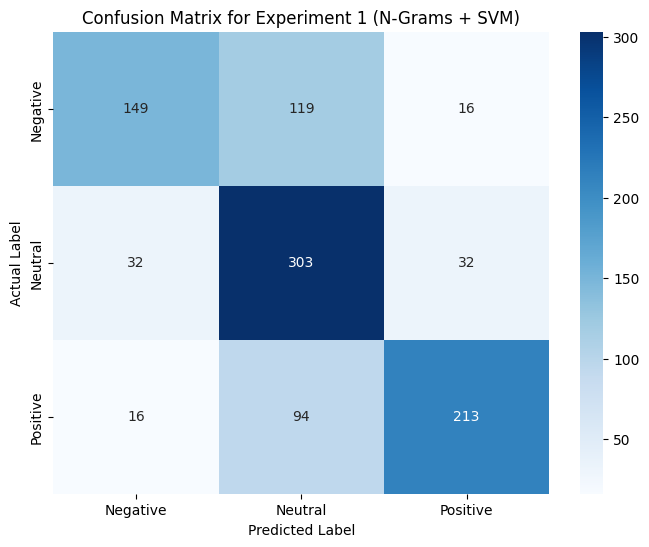

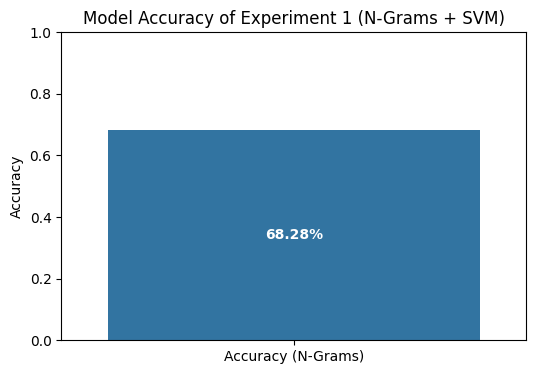

In [55]:
# Given confusion matrix values for Experiment 1 (N-Gram + SVM)
conf_matrix_ngrams = np.array([[149, 119, 16],
                               [32, 303, 32],
                               [16, 94, 213]])

# Visualizing the confusion matrix for Experiment 1
plt.figure(figsize=(8, 6))
heatmap_ngrams = sns.heatmap(conf_matrix_ngrams, annot=True, fmt='d', cmap='Blues',
                             xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix for Experiment 1 (N-Grams + SVM)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Given accuracy for Experiment 1 (N-Gram + SVM)
accuracy_ngrams = 0.6827515400410678

# Visualizing the model accuracy for Experiment 1
plt.figure(figsize=(6, 4))
sns.barplot(x=['Accuracy (N-Grams)'], y=[accuracy_ngrams])
plt.title('Model Accuracy of Experiment 1 (N-Grams + SVM)')
plt.ylabel('Accuracy')
plt.text(0, accuracy_ngrams/2, f'{accuracy_ngrams:.2%}', color='white', ha='center', va='center', fontweight='bold')
plt.ylim(0, 1)  # Set y-axis range to show percentages clearly
plt.show()

Confusion Matrix:

Negative Sentiment (0): 149 correctly classified, 119 misclassified as neutral, 16 as positive.
Neutral Sentiment (1): 303 correctly classified, 32 misclassified as negative, 32 as positive.
Positive Sentiment (2): 213 correctly classified, 94 misclassified as neutral, 16 as negative.
Accuracy:

The model's accuracy is approximately 68.28%, indicating it correctly predicts the sentiment about two-thirds of the time across all classes.

# **Experiment 2**

**Term Frequency-Inverse Document Frequency + Support Vector Machine Model**

By utilizing the TF-IDF technique, this approach will transform our lemmatized captions into a weighted matrix, emphasizing not only the frequency of each term within a caption but also its relative rarity across all documents. The resulting TF-IDF features are designed to reflect the significance of each word in capturing the essence of our textual data, preparing us for the subsequent classification task with our Support Vector Machine model

**Second Text Representation Method - TFIDF**

In [63]:
caption_lemmatized = data['Caption_Lemmatized'].astype(str)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the lemmatized captions to a TF-IDF representation
X_tfidf = tfidf_vectorizer.fit_transform(caption_lemmatized)

# Output the number of features
print(f"Number of features from TF-IDF: {X_tfidf.shape[1]}")

Number of features from TF-IDF: 10192


In delving into the intricacies of our textual data, the TF-IDF vectorization process has illuminated a rich tapestry of 10,192 unique features. Each feature represents a term from our collection of 4,869 lemmatized captions, with the TF-IDF scores articulating the relative importance of each term within the corpus. This comprehensive suite of features stands as a testament to the diversity and depth of expressions captured within our dataset, paving the way for nuanced analysis and robust sentiment classification.

**Model Training and Testing**

In [28]:
labels = data["LABEL"]
training = data["Caption_Lemmatized"]

In [29]:
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)

# Initialize the Support Vector Classifier with a linear kernel
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

In [30]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy Score Testing :")
print(accuracy_score(y_test, y_pred))

print("Confusion Matrix : ")
print(confusion_matrix(y_test,y_pred))

print("Classification Report : ")
print(classification_report(y_test,y_pred))

Accuracy Score Testing :
0.7125256673511293
Confusion Matrix : 
[[184  89  11]
 [ 50 290  27]
 [ 16  87 220]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       284
           1       0.62      0.79      0.70       367
           2       0.85      0.68      0.76       323

    accuracy                           0.71       974
   macro avg       0.74      0.71      0.71       974
weighted avg       0.73      0.71      0.71       974



In our second experiment, the refined interplay between TF-IDF features and the SVM algorithm has been brought to light. Our SVM model, operating on a vectorized space of 62,779 dimensions, has successfully grasped the essence of sentiment within our dataset, achieving an accuracy score of 71.25%. The confusion matrix illustrates a well-rounded ability to discern negative sentiments, with a majority of 184 instances being accurately identified, while 89 and 11 instances were misinterpreted as neutral and positive, respectively. The precision and recall metrics across classes depict a commendable balance, with the model showcasing a particularly strong performance in recognizing positive sentiments, denoted by an 85% precision rate. This reflects the SVM's proficiency in dealing with text classification, highlighting its capability to handle the intricacies of sentiment-dense expressions

**Visualize the Performance of Experiment 2**

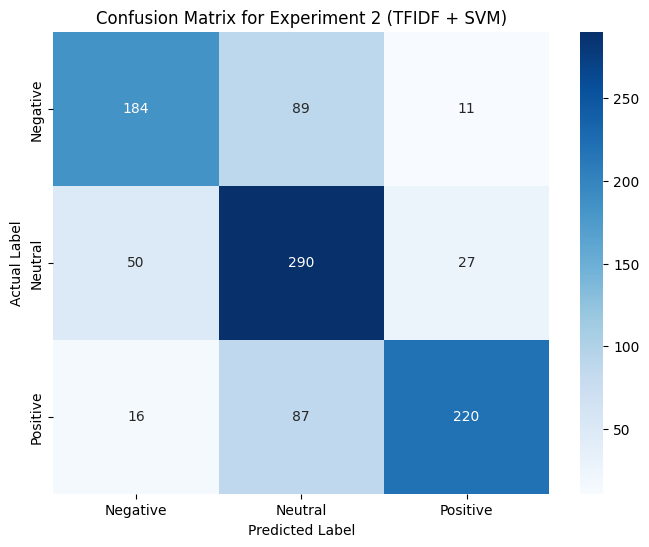

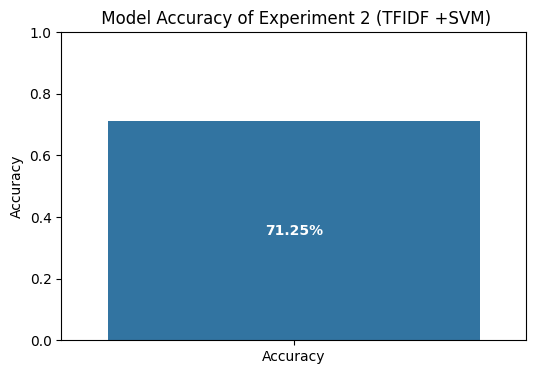

In [57]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                      xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix for Experiment 2 (TFIDF + SVM)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Re-show the accuracy as text on the plot
plt.figure(figsize=(6, 4))
sns.barplot(x=['Accuracy'], y=[accuracy])
plt.title(' Model Accuracy of Experiment 2 (TFIDF +SVM)')
plt.ylabel('Accuracy')
plt.text(0, accuracy/2, f'{accuracy:.2%}', color='white', ha='center', va='center', fontweight='bold')
plt.ylim(0, 1)  # Set y-axis range to show percentages clearly
plt.show()

**Insights:**

Confusion Matrix:

For negative sentiment (encoded as 0), 184 instances are correctly classified, while 89 are incorrectly classified as neutral, and 11 are incorrectly classified as positive.
For neutral sentiment (encoded as 1), 290 instances are correctly classified, with 50 instances incorrectly classified as negative, and 27 as positive.
For positive sentiment (encoded as 2), 220 instances are correctly classified, but there are 16 instances incorrectly classified as negative, and 87 as neutral.

Accuracy:

The model has an accuracy of approximately 71.25%. This means that it correctly predicts the sentiment 71.25% of the time across all classes.

# **Experiment 3**

**TFIDF + Random Forest**

**Third Text Representation Model - TFIDF**

In [58]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Assuming 'Caption_Lemmatized' is the column with the preprocessed text
caption_lemmatized = data['Caption_Lemmatized'].astype(str)


**Model Training and Testing**

In [59]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train_tfidf, y_train_tfidf)

# Predict on the test set
y_pred_tfidf = rf_classifier.predict(X_test_tfidf)

# Evaluate the classifier
accuracy_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
class_report_tfidf = classification_report(y_test_tfidf, y_pred_tfidf)
conf_matrix_tfidf = confusion_matrix(y_test_tfidf, y_pred_tfidf)

# Output the results
print("Accuracy Score Testing (TF-IDF + RF):", accuracy_tfidf)
print("\nConfusion Matrix (TF-IDF + RF):\n", conf_matrix_tfidf)
print("\nClassification Report (TF-IDF + RF):\n", class_report_tfidf)

Accuracy Score Testing (TF-IDF + RF): 0.688911704312115

Confusion Matrix (TF-IDF + RF):
 [[153 114  17]
 [ 41 290  36]
 [ 15  80 228]]

Classification Report (TF-IDF + RF):
               precision    recall  f1-score   support

           0       0.73      0.54      0.62       284
           1       0.60      0.79      0.68       367
           2       0.81      0.71      0.75       323

    accuracy                           0.69       974
   macro avg       0.71      0.68      0.69       974
weighted avg       0.71      0.69      0.69       974



Experiment three unfolds the narrative of integrating TF-IDF with the robust Random Forest classifier, revealing a harmony that brings forth an accuracy of approximately 68.89%. The ensemble nature of the Random Forest, with its multitude of decision trees, casts a wide net over the 62,779-dimensional feature space, capturing a substantial portion of the sentiment expressions, as evidenced by the precision scores. The confusion matrix indicates a greater challenge in pinpointing negative sentiments, with a notable number of such instances (114) being misclassified as neutral. Yet, the model demonstrates a laudable recall in the neutral category, suggesting a predilection for the more commonly expressed sentiments. The f1-scores echo the narrative of a model that, while effective, can benefit from further calibration to sharpen its discernment of the varied shades of sentiment present within the dataset

**Visualize the Performance of Experiment 3**

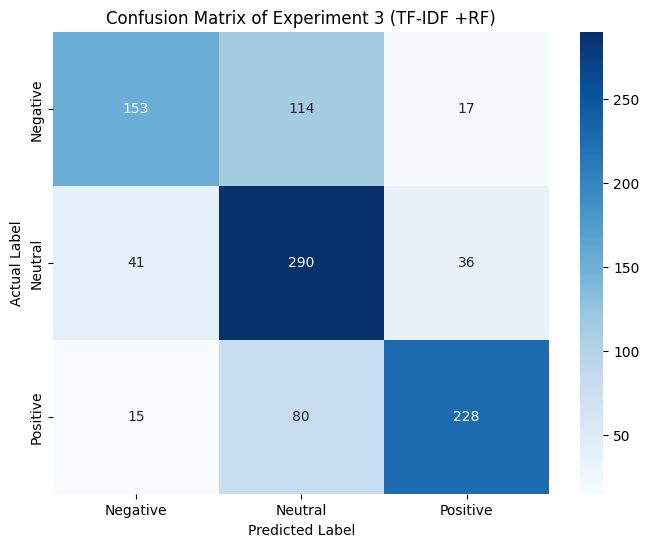

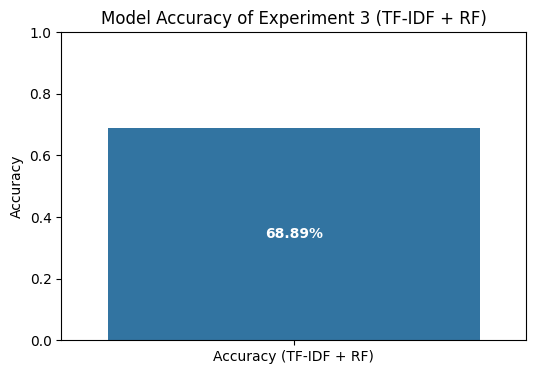

In [61]:
# Provided confusion matrix values for TF-IDF + Random Forest
conf_matrix_rf = np.array([[153, 114, 17],
                           [41, 290, 36],
                           [15, 80, 228]])

# Assuming 'encoder' has been fitted with the class labels
# Replace with actual class names if not available
class_labels = ['Negative', 'Neutral', 'Positive']  # Example class names

# Visualizing the confusion matrix for TF-IDF + Random Forest
plt.figure(figsize=(8, 6))
heatmap_rf = sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
                         xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix of Experiment 3 (TF-IDF +RF)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Provided accuracy for TF-IDF + Random Forest
accuracy_rf = 0.688911704312115

# Visualizing the model accuracy for TF-IDF + Random Forest
plt.figure(figsize=(6, 4))
sns.barplot(x=['Accuracy (TF-IDF + RF)'], y=[accuracy_rf])
plt.title('Model Accuracy of Experiment 3 (TF-IDF + RF)')
plt.ylabel('Accuracy')
plt.text(0, accuracy_rf/2, f'{accuracy_rf:.2%}', color='white', ha='center', va='center', fontweight='bold')
plt.ylim(0, 1)  # Set y-axis range to show percentages clearly
plt.show()

Insights:

Confusion Matrix:

Negative Sentiment (0): 153 correctly identified, with some confusion with Neutral (114) and fewer with Positive (17).
Neutral Sentiment (1): 290 correctly identified, though not as clear-cut, with some classified as Negative (41) and Positive (36).
Positive Sentiment (2): 228 correctly identified, showing a better distinction from Neutral (80) and Negative (15).
Accuracy:

The model reaches an accuracy of approximately 68.89%, suggesting a competent capability in classifying sentiment accurately, albeit with room for improvement, especially in distinguishing between negative and neutral sentiments.